In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')

# Define parameters
N = [5, 10, 20, 30, 50]
sequence_length = 100

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data, columns=data.columns)

/tmp/ipykernel_1644/2320590653.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


In [5]:
# Create dataset X and targets Y for each N
X_list = []
Y_list = []

for n in N:
    X = []
    Y = []
    for i in range(0,sequence_length):
        X.append(data_scaled.iloc[i:i+1, :].values)
        Y.append(data_scaled.iloc[i-1+n, data.columns.get_loc('Close')])
    X_list.append(np.array(X))
    Y_list.append(np.array(Y))


In [6]:
print(data[0:10])

              Open    High     Low   Close      Volume
Date                                                  
2006-01-03  211.47  218.05  209.32  217.83  13137450.0
2006-01-04  222.17  224.70  220.09  222.84  15292353.0
2006-01-05  223.22  226.00  220.97  225.85  10815661.0
2006-01-06  228.66  235.49  226.85  233.06  17759521.0
2006-01-09  233.44  236.94  230.70  233.68  12795837.0
2006-01-10  232.44  235.36  231.25  235.11   9104719.0
2006-01-11  235.87  237.79  234.82  236.05   9008664.0
2006-01-12  237.10  237.73  230.98  232.05  10125212.0
2006-01-13  232.39  233.68  231.04  233.36   7660220.0
2006-01-16  231.76  235.18  231.50  233.79   8335300.0


In [7]:

# Split datasets into training and testing sets
train_test_data = []
for i in range(len(N)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_list[i], Y_list[i], test_size=0.2, random_state=42
    )
    train_test_data.append((X_train, X_test, Y_train, Y_test))

In [8]:


# Define the RNN model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
Y_pred_list = []
Y_train_rescaled=[]
Y_test_rescaled=[]
Y_pred_rescaled=[]
# Train and evaluate the model for each N
for idx, n in enumerate(N):
    print(f"Training model for N={n}")
    X_train, X_test, Y_train, Y_test = train_test_data[idx]
    model = build_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

    # Evaluate the model
    loss = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Test Loss for N={n}: {loss}")

    # Generate predictions
    Y_pred_list.append(model.predict(X_test))
    
        # Rescale values back to original scale
    Y_train_rescaled.append(scaler.inverse_transform(
        np.hstack((np.zeros((len(Y_train), data.shape[1] - 1)), Y_train.reshape(-1, 1)))
    )[:, -1])
    Y_test_rescaled.append(scaler.inverse_transform(
        np.hstack((np.zeros((len(Y_test), data.shape[1] - 1)), Y_test.reshape(-1, 1)))
    )[:, -1])
    Y_pred_rescaled.append(scaler.inverse_transform(
        np.hstack((np.zeros((len(model.predict(X_test)), data.shape[1] - 1)), model.predict(X_test)))
    )[:, -1])

Training model for N=5


2024-12-13 12:19:36.957276: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 718113931264.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 629651013632.0000 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 498275123200.0000 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 480473645056.0000 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 366950219776.0000 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 294940311552.0000 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 282783055872.0000 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 186376978432.0000  
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 152308908032.0000 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 122756087808.0000 
Test Loss for N=5: 50969632768.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Training model for N=10
Epoch 1/10


/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 490513760256.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 513366097920.0000
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 411532099584.0000 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 340424884224.0000 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 311772446720.0000 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 243769393152.0000
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 260207394816.0000 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 185691668480.0000
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 164542431232.0000 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 138789650432.0000
Test Loss for N=10: 68154171392.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Training model for N=20
Epoch 1/10


/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 761608798208.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 681204645888.0000
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 673500561408.0000 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 586175479808.0000 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 467373588480.0000 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 494405484544.0000 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 335331852288.0000 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 311975116800.0000 
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 273894932480.0000 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 232261910528.0000
Test Loss for N=20: 122480058368.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Training model for N=30
Epoch 1/10


/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 540331212800.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 480808042496.0000 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 336353329152.0000 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 252756213760.0000 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 178423332864.0000 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 135590764544.0000 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 87197270016.0000  
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52134232064.0000 
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26527471616.0000 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12835570688.0000 
Test Loss for N=30: 3175502592.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Training model for N=50
Epoch 1/10


/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 304675422208.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 285374283776.0000
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 147627556864.0000 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 126711234560.0000 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 58550140928.0000
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32680599552.0000
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10905300992.0000 
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1895961984.0000 
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 102407768.0000
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1748542720.0000 
Test Loss for N=50: 2089038080.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


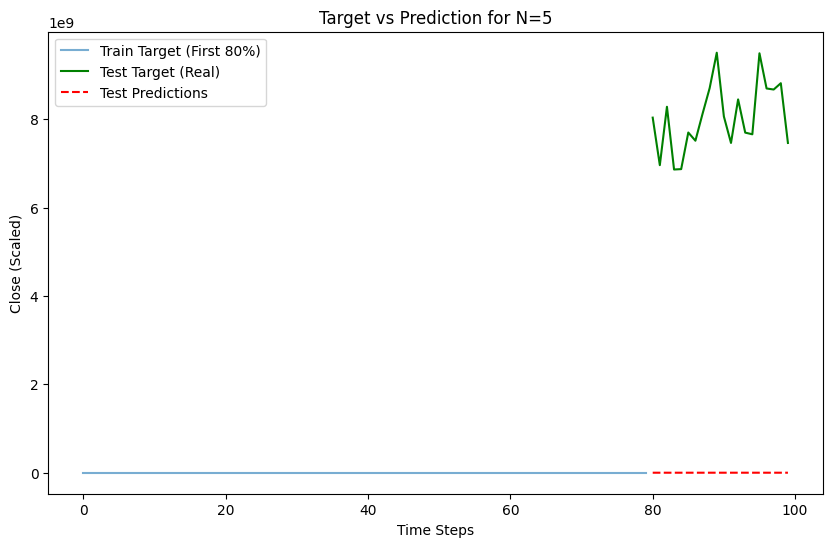

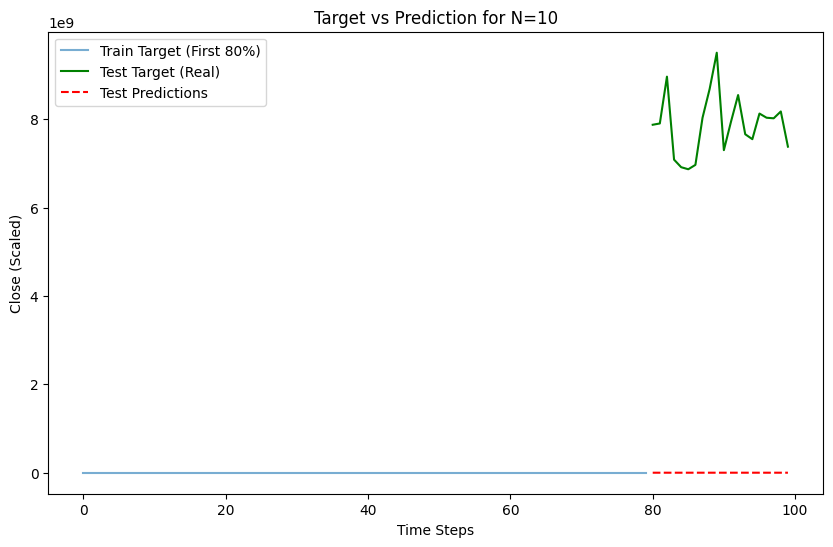

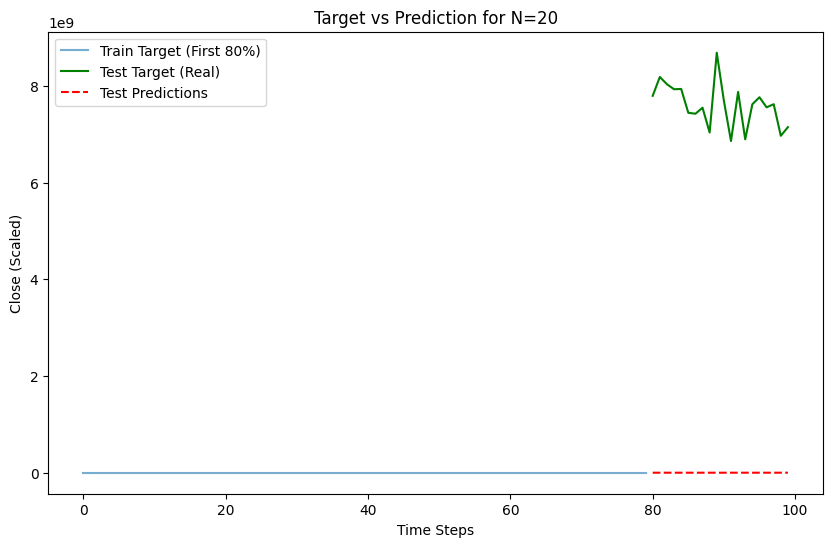

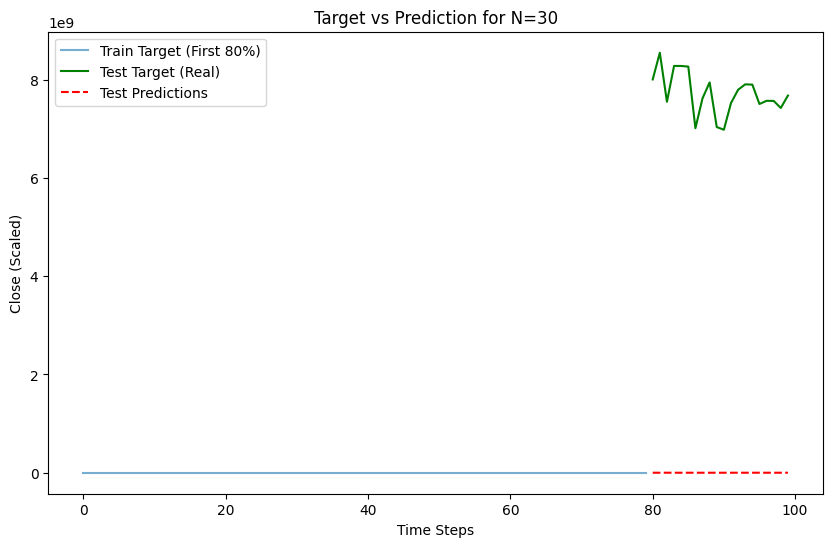

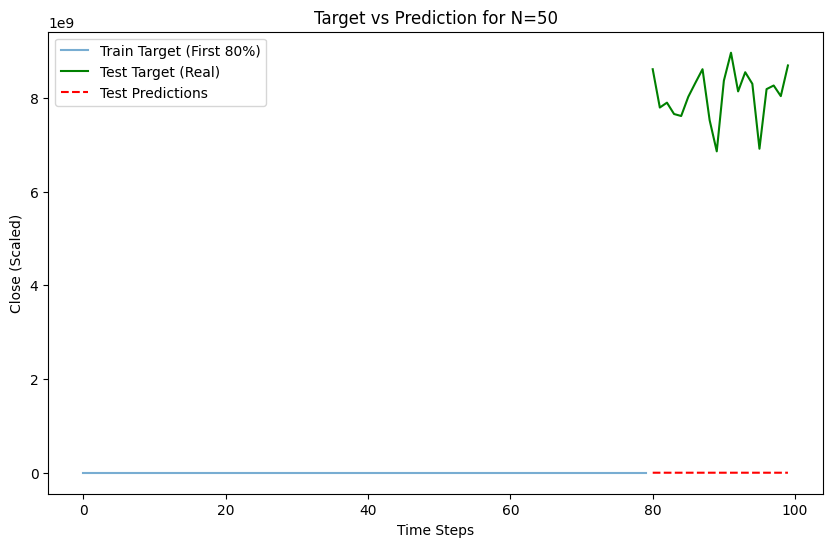

In [9]:
for n in range(len(N)):
    # Plot the results
    plt.figure(figsize=(10, 6))
    #X_train, X_test, Y_train, Y_test = train_test_data[n]
    plt.plot(range(len(Y_train_rescaled[n])), Y_train, label='Train Target (First 80%)', alpha=0.6)
    plt.plot(range(len(Y_train_rescaled[n]), len(Y_train_rescaled[n]) + len(Y_test_rescaled[n])), Y_test_rescaled[n], label='Test Target (Real)', color='green')
    plt.plot(range(len(Y_train_rescaled[n]), len(Y_train_rescaled[n]) + len(Y_pred_list[n])), Y_pred_list[n], label='Test Predictions', color='red', linestyle='dashed')
    #plt.plot(range(len(Y_train)), Y_train, label='Train Target (First 80%)', alpha=0.6)
    #plt.plot(range(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Test Target (Real)', color='green')
    #plt.plot(range(len(Y_train), len(Y_train) + len(Y_pred_list[n])), Y_pred_list[n], label='Test Predictions', color='red', linestyle='dashed')
    plt.title(f'Target vs Prediction for N={N[n]}')
    plt.xlabel('Time Steps')
    plt.ylabel('Close (Scaled)')
    plt.legend()
    plt.show()
